# Data Processing

In [9]:
import pickle
from pathlib import Path
from typing import List, Iterator

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import IterableDataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GraphUNet
from tqdm import tqdm
import matplotlib.pyplot as plt

class IterativeRolloutDataset(IterableDataset):
    """
    Yields consecutive *shifted* sequences of timesteps:
      [ (Data[t].x, Data[t+1].y), (Data[t+1].x, Data[t+2].y), ..., (Data[t+seq_len-1].x, Data[t+seq_len].y) ]
    for each simulation.
    """
    def __init__(self,
                 directory: Path,
                 hydrograph_ids: List[str],
                 seq_len: int,
                 num_static_feats: int,
                 num_dynamic_feats: int):
        """
        Args:
            directory (Path): Directory containing your pickled simulation files.
            hydrograph_ids (List[str]): List of simulation IDs (file stems).
            seq_len (int): Number of consecutive steps in each returned window.
                           NOTE: Because we shift y by +1, we actually need seq_len+1 timesteps.
            num_static_feats (int): Number of static features in data.x.
            num_dynamic_feats (int): Number of dynamic features in data.x.
        """
        super().__init__()
        self.directory = directory
        self.hydrograph_ids = hydrograph_ids
        self.seq_len = seq_len
        self.num_static_feats = num_static_feats
        self.num_dynamic_feats = num_dynamic_feats

    def __iter__(self) -> Iterator[List[Data]]:
        for hid in self.hydrograph_ids:
            pickle_file = self.directory / f"{hid}.pkl"
            try:
                with open(pickle_file, 'rb') as file:
                    sim = pickle.load(file)
                    if not isinstance(sim, list):
                        print(f"Unexpected data format in {pickle_file}. Skipping.")
                        continue
                    T = len(sim)
                    max_start = T - self.seq_len
                    if max_start < 1:
                        continue
                    for start_idx in range(max_start):
                        window = []
                        for offset in range(self.seq_len):
                            t = start_idx + offset
                            data_t = sim[t].clone()
                            # Partition x into static and dynamic parts using parameterized indices
                            static_feats = data_t.x[:, :self.num_static_feats]
                            dynamic_feats = data_t.x[:, self.num_static_feats:self.num_static_feats + self.num_dynamic_feats]
                            data_t.x = torch.cat([static_feats, dynamic_feats], dim=1)
                            # Overwrite y with next timestep's ground truth
                            data_tplus1 = sim[t+1]
                            data_t.y = data_tplus1.y.clone()
                            window.append(data_t)
                        yield window
            except FileNotFoundError:
                print(f"Pickle file not found: {pickle_file}")
            except Exception as e:
                print(f"Error loading {pickle_file}: {e}")

def get_hydrograph_ids(directory: Path) -> List[str]:
    return [file.stem for file in directory.glob("*.pkl")]


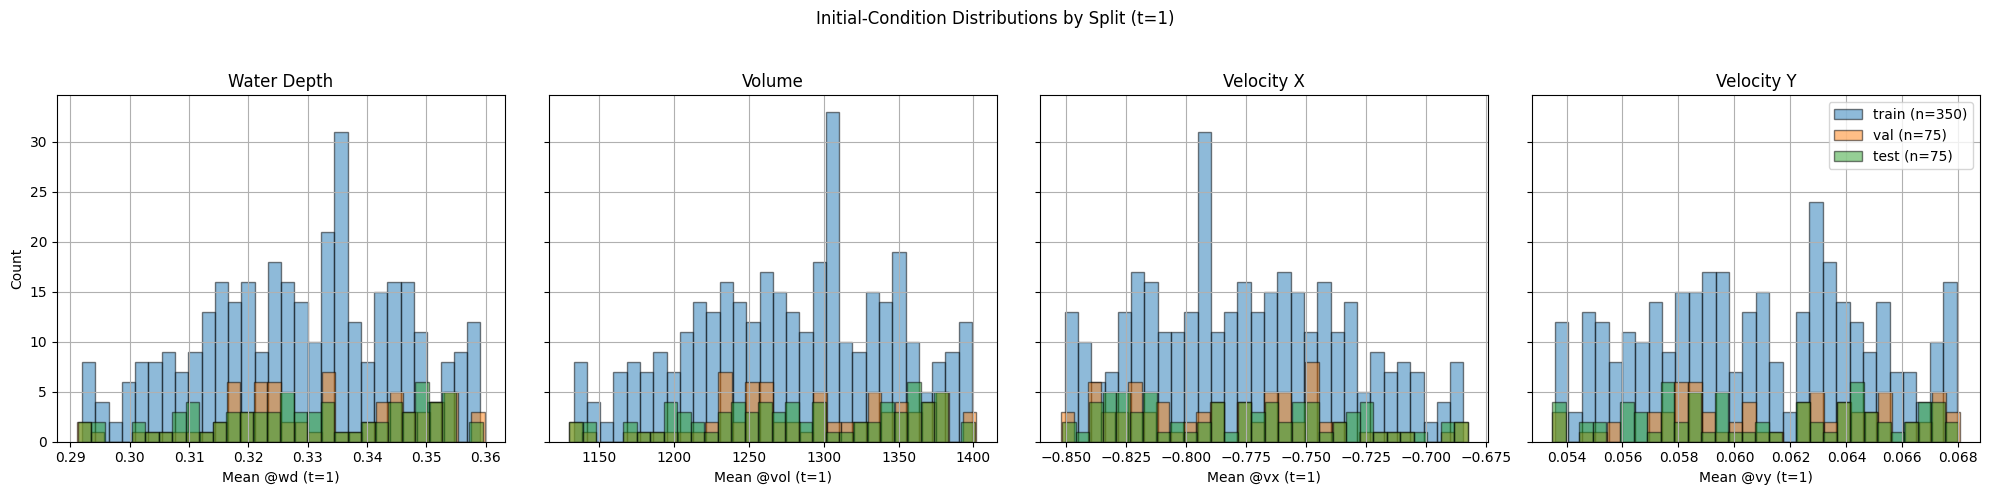

In [4]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
base_dir    = Path("/scratch/jtb3sud/combined")
splits      = {
    "train": base_dir / "train",
    "val":   base_dir / "val",
    "test":  base_dir / "test",
}
summary_txt = "initial_conditions_t0_t1_iowa.txt"

# --- 1) Load the summary file ---
# Assumes a header: run_id  inflow_t0  wd_t1_mean  vol_t1_mean  vx_t1_mean  vy_t1_mean
data = np.genfromtxt(
    summary_txt, 
    delimiter="\t", 
    names=True, 
    dtype=None, 
    encoding="utf-8"
)

# --- 2) Group records by split ---
grouped = {name: [] for name in splits}
for rec in data:
    rid = rec["run_id"]
    # look for a matching .pkl in each split folder
    for name, folder in splits.items():
        if (folder / f"{rid}.pkl").exists():
            grouped[name].append(rec)
            break

# --- 3) Prepare plotting ---
features       = ["wd_t1_mean", "vol_t1_mean", "vx_t1_mean", "vy_t1_mean"]
feature_labels = ["Water Depth", "Volume", "Velocity X", "Velocity Y"]
colors         = {"train":"C0", "val":"C1", "test":"C2"}

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for ax, feat, label in zip(axes, features, feature_labels):
    for split in ["train","val","test"]:
        recs = grouped[split]
        if not recs: 
            continue
        vals = np.array([r[feat] for r in recs])
        ax.hist(
            vals, bins=30, 
            alpha=0.5, 
            label=f"{split} (n={len(vals)})",
            color=colors[split],
            edgecolor="k"
        )
    ax.set_title(label)
    ax.set_xlabel(f"Mean @{feat.split('_')[0]} (t=1)")
    ax.grid(True)

axes[0].set_ylabel("Count")
axes[-1].legend(loc="upper right")
plt.suptitle("Initial-Condition Distributions by Split (t=1)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


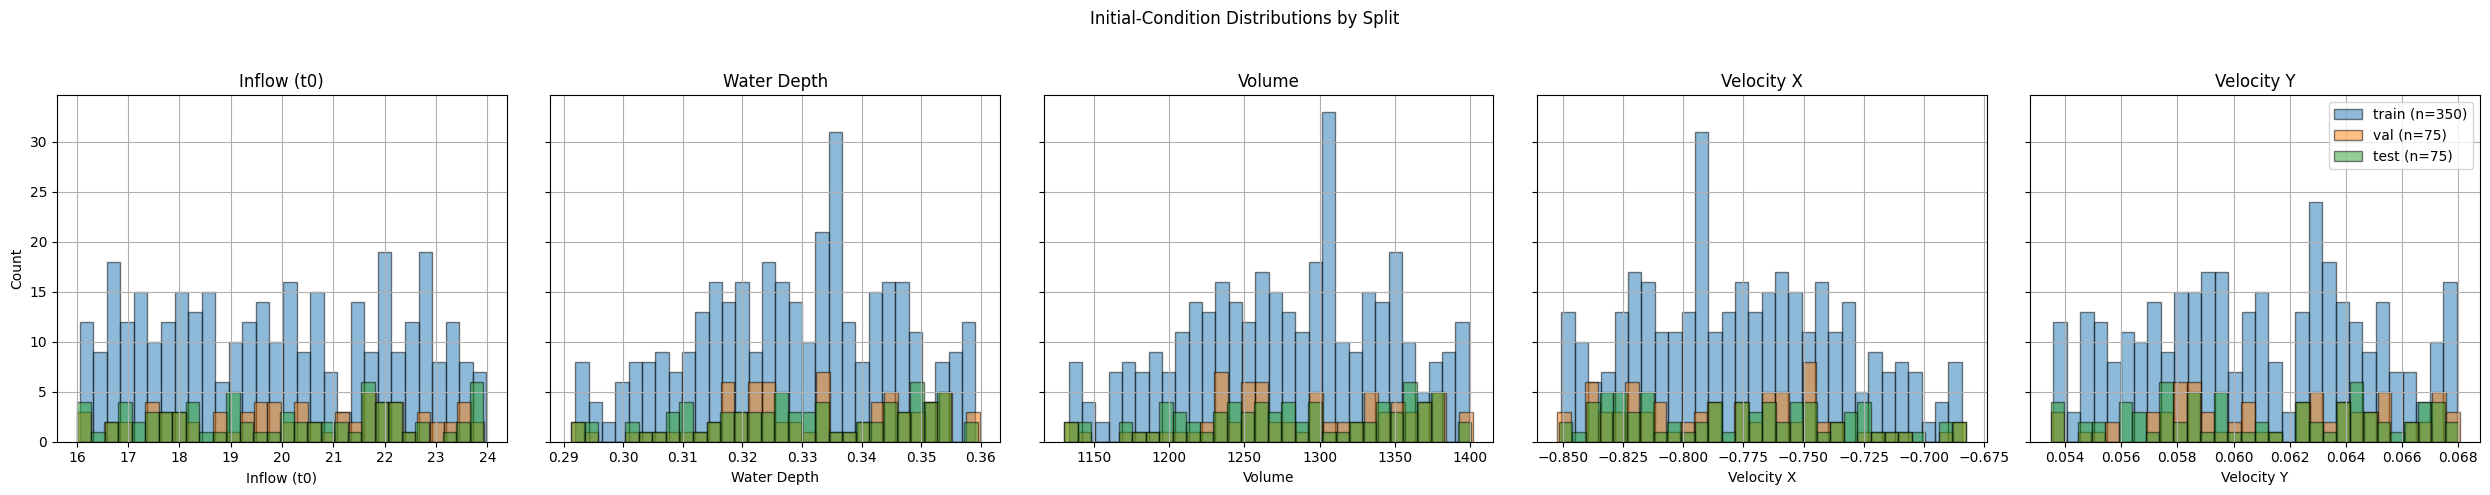

In [5]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- CONFIG ---
base_dir    = Path("/scratch/jtb3sud/combined")
splits      = {
    "train": base_dir / "train",
    "val":   base_dir / "val",
    "test":  base_dir / "test",
}
summary_txt = "initial_conditions_t0_t1_iowa.txt"

# --- 1) Load the summary file ---
# Header must be: run_id  inflow_t0  wd_t1_mean  vol_t1_mean  vx_t1_mean  vy_t1_mean
data = np.genfromtxt(
    summary_txt,
    delimiter="\t",
    names=True,
    dtype=None,
    encoding="utf-8"
)

# --- 2) Group records by split ---
grouped = {name: [] for name in splits}
for rec in data:
    rid = rec["run_id"]
    for name, folder in splits.items():
        if (folder / f"{rid}.pkl").exists():
            grouped[name].append(rec)
            break

# --- 3) Plot five histograms side-by-side ---
features       = ["inflow_t0", "wd_t1_mean", "vol_t1_mean", "vx_t1_mean", "vy_t1_mean"]
feature_labels = ["Inflow (t0)", "Water Depth", "Volume", "Velocity X", "Velocity Y"]
colors         = {"train":"C0", "val":"C1", "test":"C2"}

fig, axes = plt.subplots(1, len(features), figsize=(5 * len(features), 5), sharey=True)

for ax, feat, label in zip(axes, features, feature_labels):
    for split in ["train","val","test"]:
        recs = grouped[split]
        if not recs:
            continue
        vals = np.array([r[feat] for r in recs])
        ax.hist(
            vals,
            bins=30,
            alpha=0.5,
            label=f"{split} (n={len(vals)})",
            color=colors[split],
            edgecolor="k"
        )
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.grid(True)

axes[0].set_ylabel("Count")
axes[-1].legend(loc="upper right")
plt.suptitle("Initial-Condition Distributions by Split")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [11]:
%matplotlib inline
import numpy as np
from pathlib import Path

# — CONFIG —
base_dir    = Path("/scratch/jtb3sud/combined")    # your combined folder
summary_txt = "initial_conditions_t0_t1_iowa.txt"  # or white

# 1) Load the summary file
#    Must have header: run_id  inflow_t0  wd_t1_mean  vol_t1_mean  vx_t1_mean  vy_t1_mean
data = np.genfromtxt(
    summary_txt,
    delimiter="\t",
    names=True,
    dtype=None,
    encoding="utf-8"
)

# 2) Build split‐folders lookup
splits = {
    "train": base_dir / "train",
    "val":   base_dir / "val",
    "test":  base_dir / "test",
}

# 3) Group each record by which split contains its .pkl
grouped = {name: [] for name in splits}
for rec in data:
    rid = rec["run_id"]
    for name, folder in splits.items():
        if (folder / f"{rid}iw.pkl").exists():
            grouped[name].append(rec)
            break

# quick check
print({k: len(v) for k,v in grouped.items()})


{'train': 350, 'val': 75, 'test': 75}


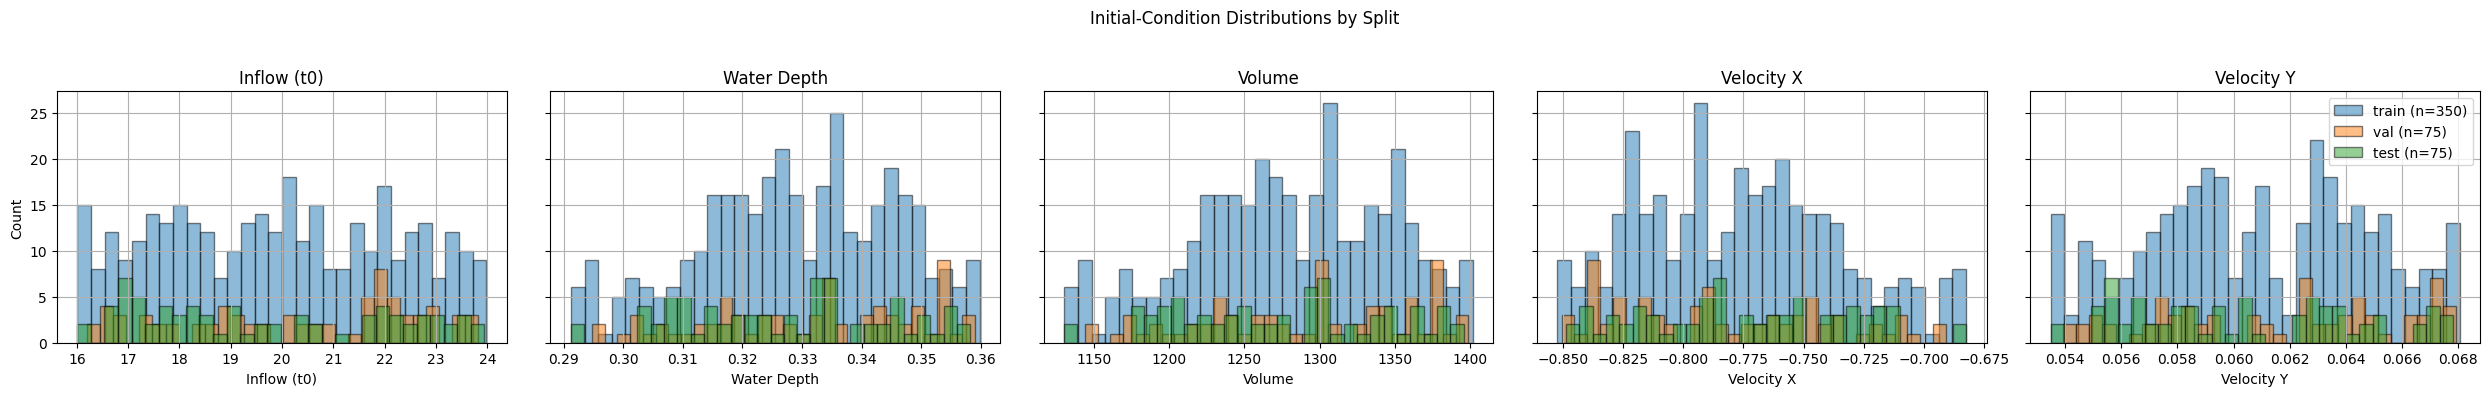

In [12]:
import matplotlib.pyplot as plt

features       = ["inflow_t0", "wd_t1_mean", "vol_t1_mean", "vx_t1_mean", "vy_t1_mean"]
feature_labels = ["Inflow (t0)", "Water Depth", "Volume", "Velocity X", "Velocity Y"]
colors         = {"train":"C0", "val":"C1", "test":"C2"}

fig, axes = plt.subplots(1, len(features), figsize=(5*len(features), 4), sharey=True)
for ax, feat, lbl in zip(axes, features, feature_labels):
    for split in ["train","val","test"]:
        recs = grouped[split]
        if not recs: continue
        vals = np.array([r[feat] for r in recs])
        ax.hist(vals, bins=30, alpha=0.5, 
                label=f"{split} (n={len(vals)})", 
                color=colors[split], edgecolor="k")
    ax.set_title(lbl)
    ax.set_xlabel(lbl)
    ax.grid(True)

axes[0].set_ylabel("Count")
axes[-1].legend(loc="upper right")
plt.suptitle("Initial-Condition Distributions by Split")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


In [13]:
%matplotlib inline
import numpy as np
from pathlib import Path

# — CONFIG —
base_dir    = Path("/scratch/jtb3sud/combined")    # your combined folder
summary_txt = "initial_conditions_t0_t1_white.txt"  # or white

# 1) Load the summary file
#    Must have header: run_id  inflow_t0  wd_t1_mean  vol_t1_mean  vx_t1_mean  vy_t1_mean
data = np.genfromtxt(
    summary_txt,
    delimiter="\t",
    names=True,
    dtype=None,
    encoding="utf-8"
)

# 2) Build split‐folders lookup
splits = {
    "train": base_dir / "train",
    "val":   base_dir / "val",
    "test":  base_dir / "test",
}

# 3) Group each record by which split contains its .pkl
grouped = {name: [] for name in splits}
for rec in data:
    rid = rec["run_id"]
    for name, folder in splits.items():
        if (folder / f"{rid}.pkl").exists():
            grouped[name].append(rec)
            break

# quick check
print({k: len(v) for k,v in grouped.items()})


{'train': 350, 'val': 75, 'test': 75}


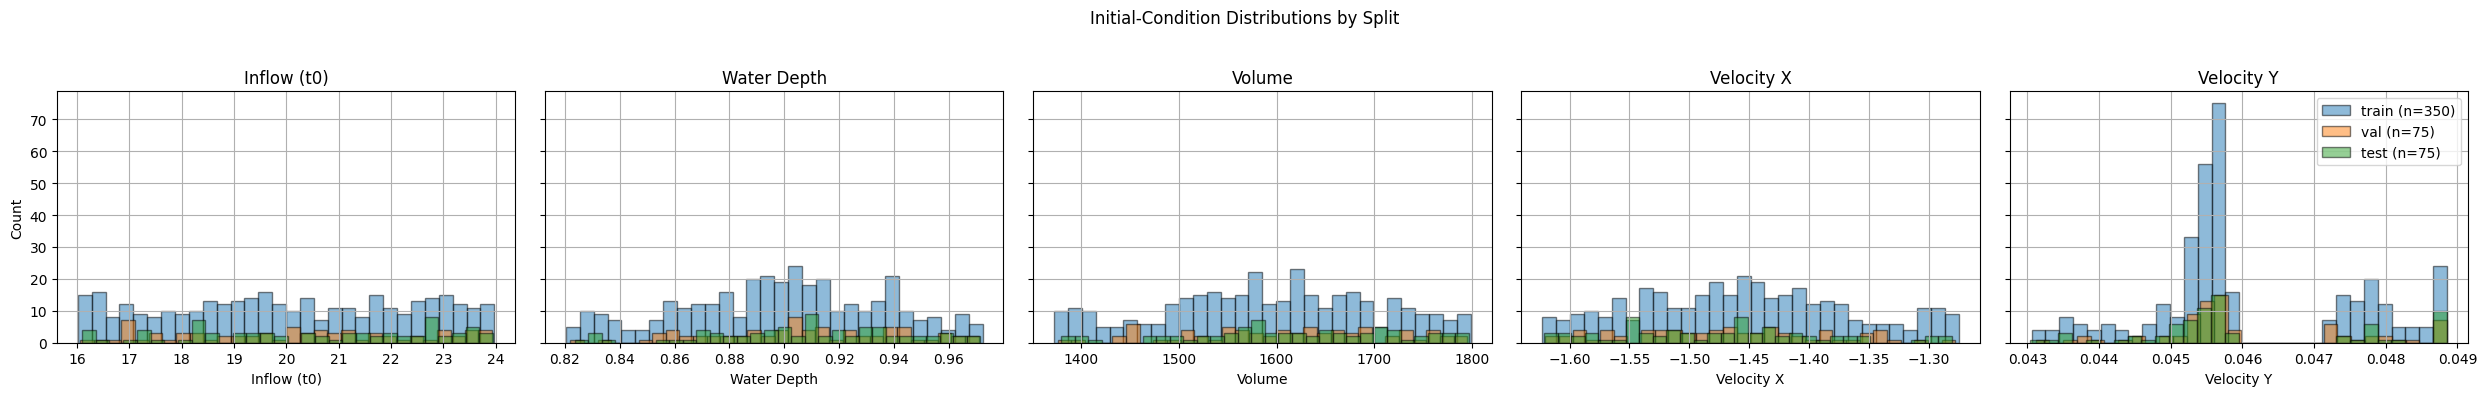

done


In [15]:
import matplotlib.pyplot as plt

features       = ["inflow_t0", "wd_t1_mean", "vol_t1_mean", "vx_t1_mean", "vy_t1_mean"]
feature_labels = ["Inflow (t0)", "Water Depth", "Volume", "Velocity X", "Velocity Y"]
colors         = {"train":"C0", "val":"C1", "test":"C2"}

fig, axes = plt.subplots(1, len(features), figsize=(5*len(features), 4), sharey=True)
for ax, feat, lbl in zip(axes, features, feature_labels):
    for split in ["train","val","test"]:
        recs = grouped[split]
        if not recs: continue
        vals = np.array([r[feat] for r in recs])
        ax.hist(vals, bins=30, alpha=0.5, 
                label=f"{split} (n={len(vals)})", 
                color=colors[split], edgecolor="k")
    ax.set_title(lbl)
    ax.set_xlabel(lbl)
    ax.grid(True)

axes[0].set_ylabel("Count")
axes[-1].legend(loc="upper right")
plt.suptitle("Initial-Condition Distributions by Split")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
print("done")


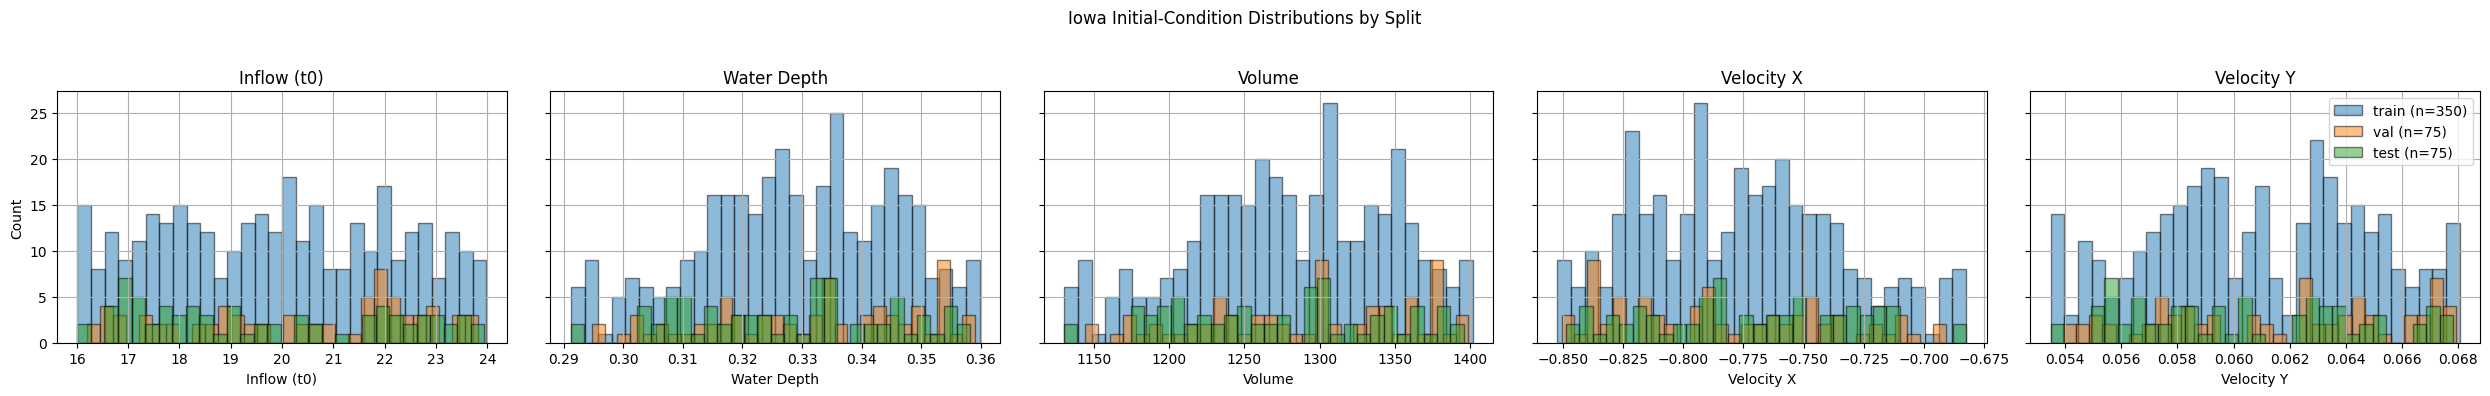

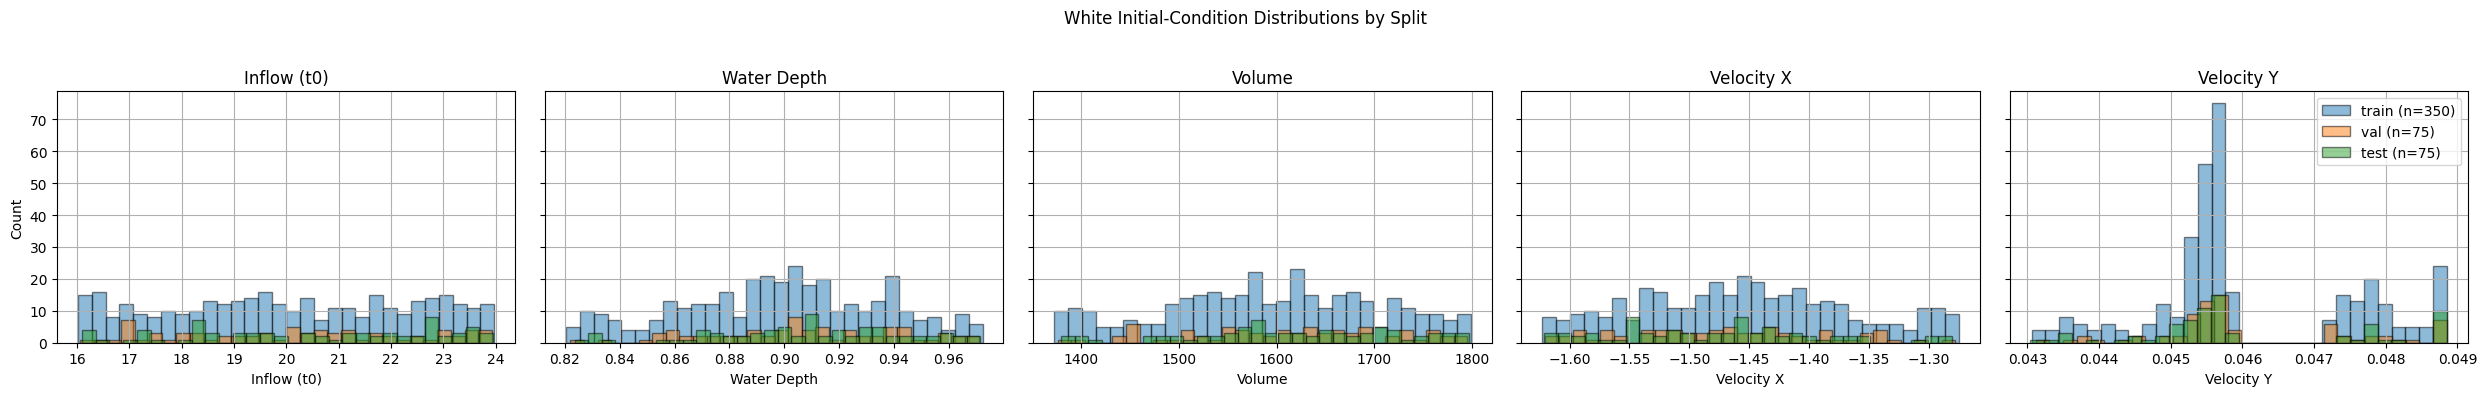

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_ic_distributions(summary_txt: str, base_dir: Path, label: str):
    """
    summary_txt: path to the tab-delimited file with columns
        run_id, inflow_t0, wd_t1_mean, vol_t1_mean, vx_t1_mean, vy_t1_mean
    base_dir: parent folder containing train/, val/, test/ subfolders
    label: "Iowa" or "White" — determines whether to look for rid+'iw'.pkl or rid+'.pkl'
    """
    # 1) Load summary
    data = np.genfromtxt(
        summary_txt,
        delimiter="\t",
        names=True,
        dtype=None,
        encoding="utf-8"
    )

    # 2) Prepare split folders
    splits = {
        "train": base_dir / "train",
        "val":   base_dir / "val",
        "test":  base_dir / "test",
    }

    # 3) Group records by split, using correct suffix for Iowa vs White
    grouped = {name: [] for name in splits}
    for rec in data:
        rid = rec["run_id"]
        for name, folder in splits.items():
            if label == "Iowa":
                pkl = folder / f"{rid}iw.pkl"
            else:
                pkl = folder / f"{rid}.pkl"
            if pkl.exists():
                grouped[name].append(rec)
                break

    # 4) Plotting
    features       = ["inflow_t0", "wd_t1_mean", "vol_t1_mean", "vx_t1_mean", "vy_t1_mean"]
    feature_labels = ["Inflow (t0)", "Water Depth", "Volume", "Velocity X", "Velocity Y"]
    colors         = {"train":"C0", "val":"C1", "test":"C2"}

    fig, axes = plt.subplots(1, len(features), figsize=(5*len(features), 4), sharey=True)
    for ax, feat, lbl in zip(axes, features, feature_labels):
        for split in ["train","val","test"]:
            recs = grouped[split]
            if not recs:
                continue
            vals = np.array([r[feat] for r in recs])
            ax.hist(vals, bins=30, alpha=0.5,
                    label=f"{split} (n={len(vals)})",
                    color=colors[split], edgecolor="k")
        ax.set_title(lbl)
        ax.set_xlabel(lbl)
        ax.grid(True)

    axes[0].set_ylabel("Count")
    axes[-1].legend(loc="upper right")
    plt.suptitle(f"{label} Initial-Condition Distributions by Split")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


# ——— run for Iowa ———
base_dir = Path("/scratch/jtb3sud/combined")
plot_ic_distributions(
    summary_txt="initial_conditions_t0_t1_iowa.txt",
    base_dir=base_dir,
    label="Iowa"
)

# ——— run for White ———
plot_ic_distributions(
    summary_txt="initial_conditions_t0_t1_white.txt",
    base_dir=base_dir,
    label="White"
)


In [2]:
%matplotlib inline
import numpy as np
from pathlib import Path

# — CONFIG —
base_dir = Path("/scratch/jtb3sud/combined")
summary_files = {
    "Iowa":  Path("initial_conditions_t0_t1_iowa.txt"),
    "White": Path("initial_conditions_t0_t1_white.txt"),
}

# 1) Load & tag each summary record with its river
records = []
for river, fn in summary_files.items():
    data = np.genfromtxt(
        fn,
        delimiter="\t",
        names=True,
        dtype=None,
        encoding="utf-8"
    )
    for rec in data:
        rec_dict = {field: rec[field] for field in data.dtype.names}
        rec_dict["river"] = river
        records.append(rec_dict)

# 2) Prepare split‐folders lookup
splits = {
    "train": base_dir / "train",
    "val":   base_dir / "val",
    "test":  base_dir / "test",
}

# 3) Group into train/val/test, using river‐aware suffix logic
grouped = {name: [] for name in splits}
for rec in records:
    rid   = rec["run_id"]
    river = rec["river"]
    for split_name, folder in splits.items():
        if river == "Iowa":
            candidate = folder / f"{rid}iw.pkl"
        else:
            candidate = folder / f"{rid}.pkl"
        if candidate.exists():
            grouped[split_name].append(rec)
            break

# 4) Quick sanity check
print("counts by split:", {k: len(v) for k, v in grouped.items()})


counts by split: {'train': 700, 'val': 150, 'test': 150}


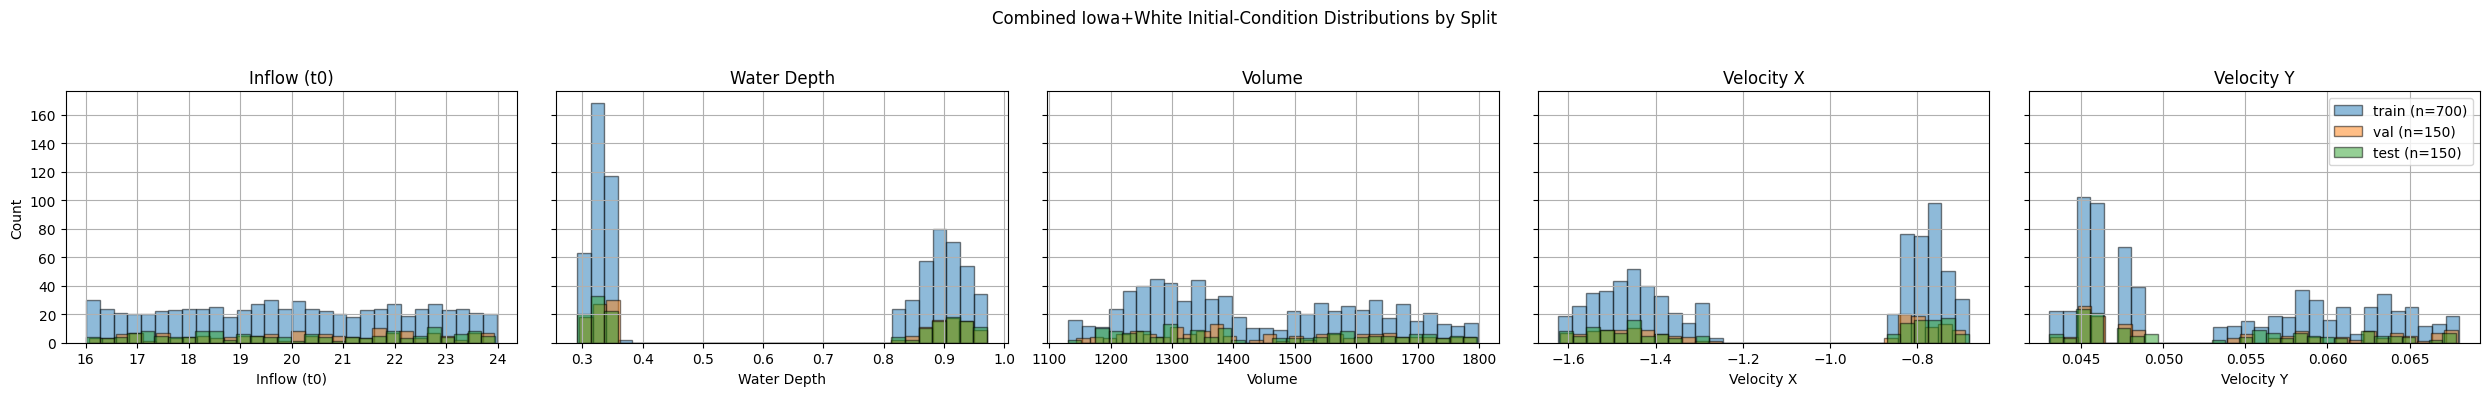

In [21]:
import matplotlib.pyplot as plt

# features and labels
features       = ["inflow_t0", "wd_t1_mean", "vol_t1_mean", "vx_t1_mean", "vy_t1_mean"]
feature_labels = ["Inflow (t0)", "Water Depth", "Volume", "Velocity X", "Velocity Y"]
colors         = {"train":"C0", "val":"C1", "test":"C2"}

fig, axes = plt.subplots(1, len(features), figsize=(5*len(features), 4), sharey=True)
for ax, feat, lbl in zip(axes, features, feature_labels):
    for split_name in ["train", "val", "test"]:
        recs = grouped[split_name]
        if not recs:
            continue
        vals = np.array([r[feat] for r in recs])
        ax.hist(vals, bins=30, alpha=0.5,
                label=f"{split_name} (n={len(vals)})",
                color=colors[split_name], edgecolor="k")
    ax.set_title(lbl)
    ax.set_xlabel(lbl)
    ax.grid(True)

axes[0].set_ylabel("Count")
axes[-1].legend(loc="upper right")
plt.suptitle("Combined Iowa+White Initial-Condition Distributions by Split")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


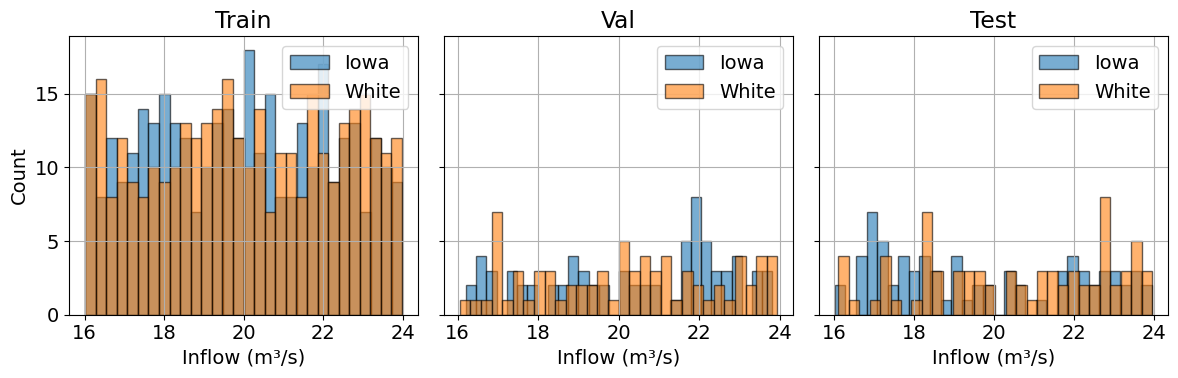

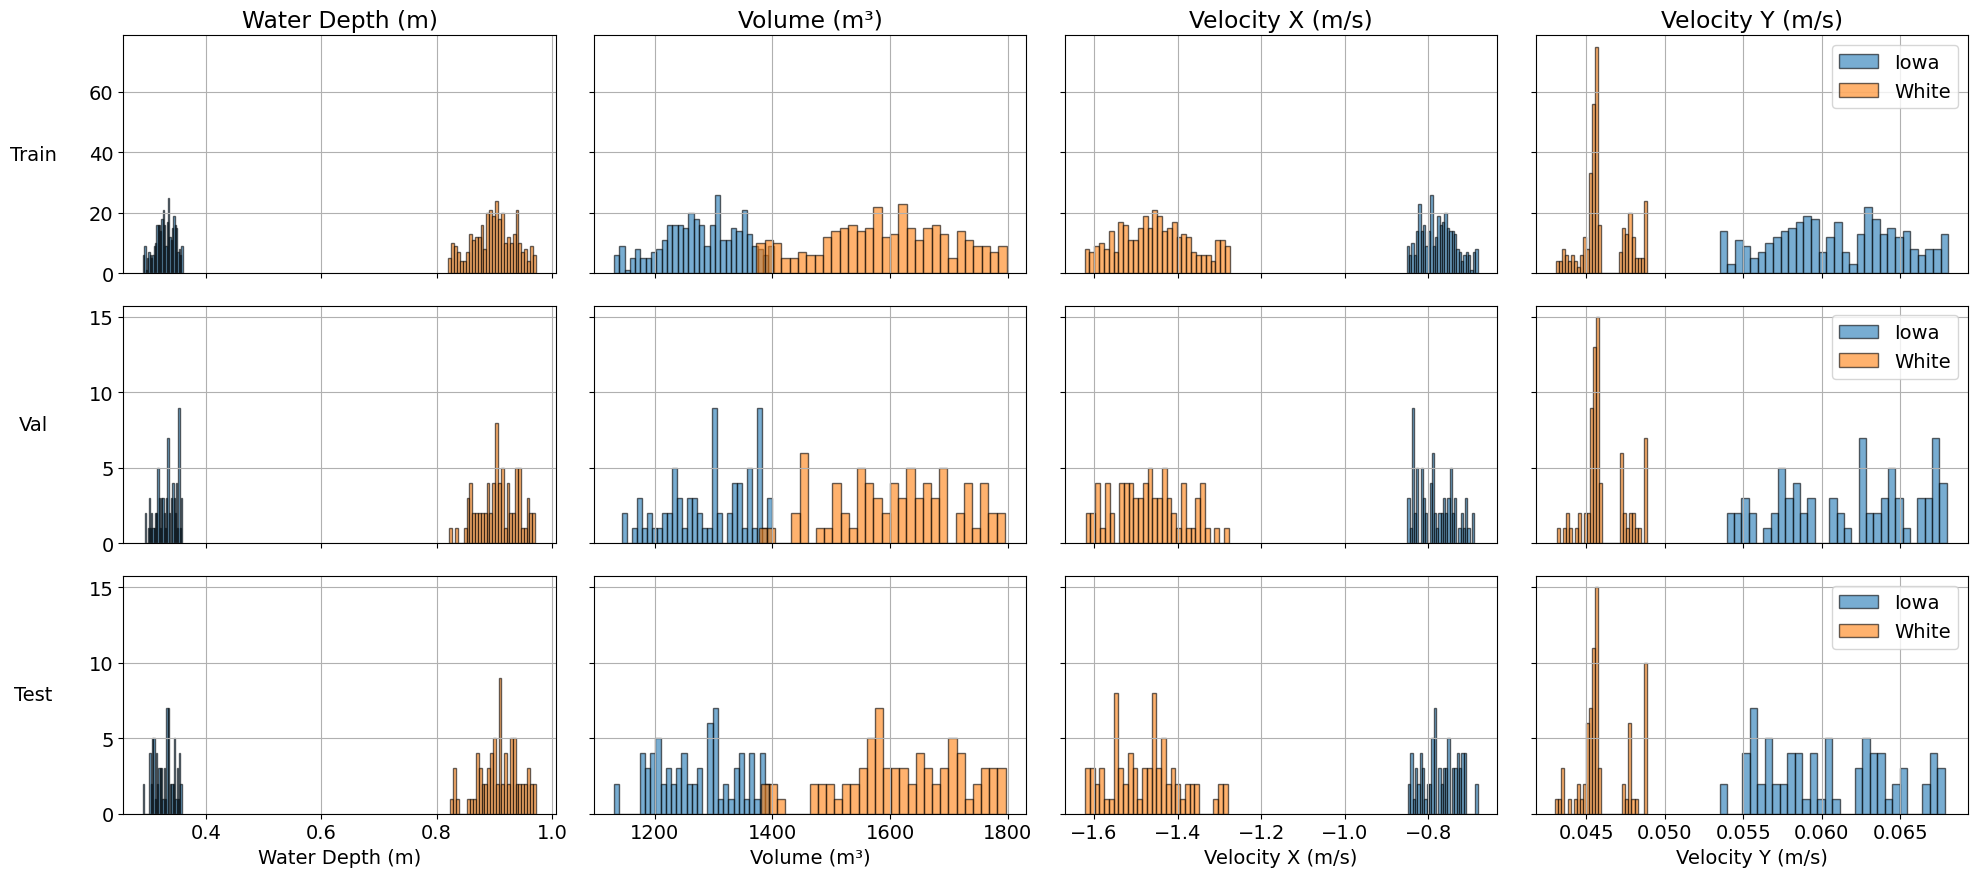

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# — FEATURES & STYLING WITH UNITS —
features       = ["inflow_t0",   "wd_t1_mean",   "vol_t1_mean",  "vx_t1_mean",    "vy_t1_mean"]
feature_labels = [
    "Inflow (m³/s)", 
    "Water Depth (m)", 
    "Volume (m³)", 
    "Velocity X (m/s)", 
    "Velocity Y (m/s)"
]
rivers         = ["Iowa", "White"]
river_colors   = {"Iowa":"C0", "White":"C1"}
splits         = ["train", "val", "test"]

plt.rcParams.update({'font.size': 14})

# — FIGURE 1: Inflow only (horizontal) —
fig1, axes1 = plt.subplots(
    nrows=1,
    ncols=len(splits),
    figsize=(4*len(splits), 4),
    sharey=True
)
for j, split in enumerate(splits):
    recs = grouped[split]
    ax = axes1[j]
    for river in rivers:
        vals = [r["inflow_t0"] for r in recs if r["river"] == river]
        if vals:
            ax.hist(vals, bins=30, alpha=0.6,
                    label=river,
                    color=river_colors[river],
                    edgecolor="k")
    # formatting
    if j == 0:
        ax.set_ylabel("Count")
    ax.set_title(split.capitalize())
    ax.set_xlabel(feature_labels[0])   # Inflow (m³/s)
    ax.legend(loc="upper right")
    ax.grid(True)

fig1.tight_layout()
fig1.savefig("inflow_horizontal_with_units.png")
plt.show()


# — FIGURE 2: The other four features —
other_feats  = features[1:]
other_labels = feature_labels[1:]

fig2, axes2 = plt.subplots(
    nrows=len(splits),
    ncols=len(other_feats),
    figsize=(5*len(other_feats), 3*len(splits)),
    sharex='col',
    sharey='row'
)
for i, split in enumerate(splits):
    recs = grouped[split]
    for j, (feat, lbl) in enumerate(zip(other_feats, other_labels)):
        ax = axes2[i, j]
        for river in rivers:
            vals = [r[feat] for r in recs if r["river"] == river]
            if vals:
                ax.hist(vals, bins=30, alpha=0.6,
                        label=river,
                        color=river_colors[river],
                        edgecolor="k")
        # formatting
        if i == 0:
            ax.set_title(lbl)             # e.g. "Water Depth (m)"
        if j == 0:
            ax.set_ylabel(split.capitalize(), rotation=0, labelpad=40, va='center')
        if i == len(splits)-1:
            ax.set_xlabel(lbl)             # e.g. "Volume (m³)"
        if j == len(other_feats)-1:
            ax.legend(loc="upper right")
        ax.grid(True)

fig2.tight_layout()
fig2.savefig("other_features_with_units.png")
plt.show()
